# Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Define constants and data transformations

In [3]:
BATCH_SIZE = 64
PIN_MEMORY = True if 'cuda' else False

In [61]:
transform_train = torchvision.transforms.Compose([
                                            torchvision.transforms.Resize((32, 32)),
                                            torchvision.transforms.RandomHorizontalFlip(),
                                            torchvision.transforms.RandomRotation(10),  
                                            torchvision.transforms.ToTensor(), 
                                            torchvision.transforms.Normalize((.5, .5, .5), (.5, .5, .5))
])

transform_test = torchvision.transforms.Compose([
                                            torchvision.transforms.ToTensor(), 
                                            torchvision.transforms.Normalize((.5, .5, .5), (.5, .5, .5))    
])

# Load data

In [5]:
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=PIN_MEMORY)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=PIN_MEMORY)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
classes = {
    0: 'airplane',
    1: 'autmobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck'
}

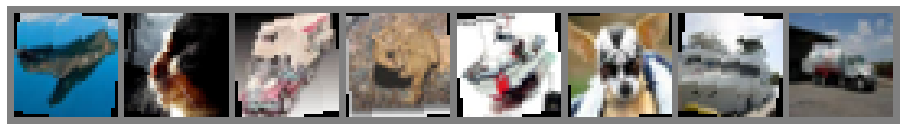

airplane           cat         truck          frog          ship           dog          ship         truck


In [7]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

train_iter = iter(train_loader)
images, labels = next(train_iter)

plt.rcParams['figure.figsize'] = (16, 8)
img_num = 8
img_grid = torchvision.utils.make_grid(images[:img_num])
imshow(img_grid)
print('         '.join('%5s' % classes[labels[j].item()] for j in range(img_num)))

# Create CNN model

In [8]:
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()

    self.conv1 = nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=2)
    self.batch_norm1 = nn.BatchNorm2d(32)
    self.conv2 = nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2)
    self.batch_norm2 = nn.BatchNorm2d(64)
    self.conv3 = nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=0)
    self.batch_norm3 = nn.BatchNorm2d(128)
    self.max_pool1 = nn.MaxPool2d(kernel_size=2, stride=2)                
    self.conv4 = nn.Conv2d(128, 256, kernel_size=5, stride=1, padding=0)   
    self.batch_norm4 = nn.BatchNorm2d(256)
    self.max_pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.dropout1 = nn.Dropout(.5)
    self.fc1 = nn.Linear(in_features=256*5*5, out_features=1024)
    self.dropout2 = nn.Dropout(.5)
    self.fc2 = nn.Linear(in_features=1024, out_features=1024)
    self.dropout3 = nn.Dropout(.5)
    self.fc3 = nn.Linear(in_features=1024, out_features=10)


  def forward(self, x):
    out = F.relu(self.batch_norm1(self.conv1(x)))
    out = F.relu(self.batch_norm2(self.conv2(out)))
    out = F.relu(self.batch_norm3(self.conv3(out)))
    out = self.max_pool1(out)
    out = F.relu(self.batch_norm4(self.conv4(out)))
    out = self.max_pool2(out)

    out = out.view(out.shape[0], -1)

    out = self.dropout1(out)
    out = F.relu(self.fc1(out))
    out = self.dropout2(out)
    out = F.relu(self.fc2(out))
    out = self.dropout3(out)
    out = self.fc3(out)

    return out

In [9]:
cnn = CNN().to(device)
optimizer = torch.optim.Adam(cnn.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

In [10]:
epochs = 25
train_loss = []
train_accuracy = []
val_loss = []
val_accuracy = []

for epoch in tqdm(range(epochs), leave=True, position=0):
  running_train_loss = 0.
  correct = 0
  total = 0
  for (x_train, y_train) in tqdm(train_loader):
    optimizer.zero_grad()

    out = cnn(x_train.to(device))

    _, preds = torch.max(out.data, 1)
    total += y_train.shape[0]
    correct += (preds == y_train.to(device)).sum().item()
    loss = criterion(out, y_train.to(device))

    running_train_loss += loss.item()

    loss.backward()
    optimizer.step()
  train_loss.append(running_train_loss/(len(train_loader)))
  train_accuracy.append(correct/total)

  with torch.no_grad():
    cnn.eval()
    running_val_loss = 0.
    correct = 0
    total = 0
    for (x_test, y_test) in test_loader:
      out = cnn(x_test.to(device))

      _, preds = torch.max(out.data, 1)
      total += y_test.shape[0]
      correct += (preds == y_test.to(device)).sum().item()
      loss = criterion(out, y_test.to(device))
      running_val_loss += loss.item()
    val_loss.append(running_val_loss/(len(test_loader)))
    val_accuracy.append(correct/total)
    cnn.train()

  tqdm.write(f'Epoch: {epoch+1} - train_loss: {train_loss[-1]} - train_accuracy: {train_accuracy[-1]} - val_loss: {val_loss[-1]} - val_accuracy: {val_accuracy[-1]}')


Epoch: 1 - train_loss: 1.5185549897153665 - train_accuracy: 0.43842 - val_loss: 1.1341816429879255 - val_accuracy: 0.5859



Epoch: 2 - train_loss: 1.1411020375426164 - train_accuracy: 0.5909 - val_loss: 0.9902257061308357 - val_accuracy: 0.6477



Epoch: 3 - train_loss: 0.9889911333160937 - train_accuracy: 0.64984 - val_loss: 0.8488922047007615 - val_accuracy: 0.7036



Epoch: 4 - train_loss: 0.9012650368006333 - train_accuracy: 0.68262 - val_loss: 0.7584490998155752 - val_accuracy: 0.7383



Epoch: 5 - train_loss: 0.835231638358682 - train_accuracy: 0.70548 - val_loss: 0.7339206104445609 - val_accuracy: 0.7476



Epoch: 6 - train_loss: 0.7887604342930762 - train_accuracy: 0.72578 - val_loss: 0.67381069405823 - val_accuracy: 0.7683



Epoch: 7 - train_loss: 0.7471765142953609 - train_accuracy: 0.73932 - val_loss: 0.6422301969330781 - val_accuracy: 0.7815



Epoch: 8 - train_loss: 0.7103032346271798 - train_accuracy: 0.75204 - val_loss: 0.6504613195255304 - val_accuracy: 0.7788



Epoch: 9 - train_loss: 0.6839860840831571 - train_accuracy: 0.76222 - val_loss: 0.587110856346264 - val_accuracy: 0.7969



Epoch: 10 - train_loss: 0.6572262283100192 - train_accuracy: 0.77366 - val_loss: 0.5835585992807036 - val_accuracy: 0.798



Epoch: 11 - train_loss: 0.6370132107030401 - train_accuracy: 0.77764 - val_loss: 0.5786966653006851 - val_accuracy: 0.8042



Epoch: 12 - train_loss: 0.6121181236279895 - train_accuracy: 0.7859 - val_loss: 0.5489575988168169 - val_accuracy: 0.81



Epoch: 13 - train_loss: 0.590330743709641 - train_accuracy: 0.79398 - val_loss: 0.5460776006150397 - val_accuracy: 0.8142



Epoch: 14 - train_loss: 0.5751066203312496 - train_accuracy: 0.79922 - val_loss: 0.5202780493125794 - val_accuracy: 0.8216



Epoch: 15 - train_loss: 0.5560569272702917 - train_accuracy: 0.80672 - val_loss: 0.5126032002602413 - val_accuracy: 0.8239



Epoch: 16 - train_loss: 0.5428933918171222 - train_accuracy: 0.81204 - val_loss: 0.4993709262199463 - val_accuracy: 0.8277



Epoch: 17 - train_loss: 0.5276093321383152 - train_accuracy: 0.8176 - val_loss: 0.4961454078650019 - val_accuracy: 0.8317



Epoch: 18 - train_loss: 0.5211250042099782 - train_accuracy: 0.81972 - val_loss: 0.48341775500470663 - val_accuracy: 0.8384



Epoch: 19 - train_loss: 0.49932728425773515 - train_accuracy: 0.8268 - val_loss: 0.5124232990157073 - val_accuracy: 0.8221



Epoch: 20 - train_loss: 0.49410624419103194 - train_accuracy: 0.83014 - val_loss: 0.47529244954418987 - val_accuracy: 0.8415



Epoch: 21 - train_loss: 0.47930441621471853 - train_accuracy: 0.8315 - val_loss: 0.4735340315635037 - val_accuracy: 0.8412



Epoch: 22 - train_loss: 0.4678641547975333 - train_accuracy: 0.83806 - val_loss: 0.46529302318954163 - val_accuracy: 0.8447



Epoch: 23 - train_loss: 0.4625361296717468 - train_accuracy: 0.83822 - val_loss: 0.46347896678812184 - val_accuracy: 0.8421



Epoch: 24 - train_loss: 0.44499158451471793 - train_accuracy: 0.84532 - val_loss: 0.4610190140973231 - val_accuracy: 0.8452



Epoch: 25 - train_loss: 0.44068507432861403 - train_accuracy: 0.84704 - val_loss: 0.46886994324292347 - val_accuracy: 0.8418



# Plot loss and accuracy on train and validation sets

Text(0.5, 0.98, 'Loss per epoch')

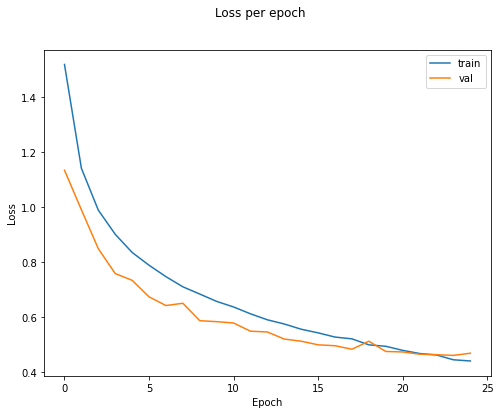

In [18]:
plt.rcParams['figure.figsize'] = (8, 6)
plt.plot(train_loss, label='train')
plt.plot(val_loss, label='val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.suptitle('Loss per epoch')

Text(0.5, 0.98, 'Accuracy per epoch')

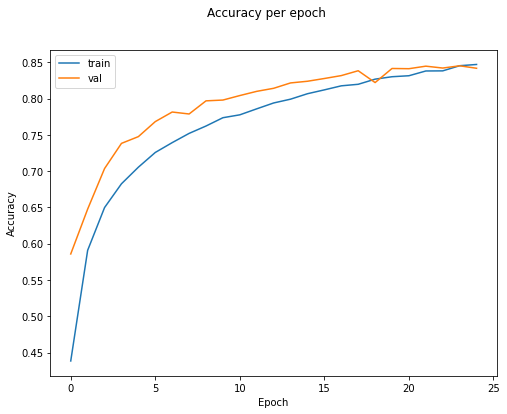

In [19]:
plt.plot(train_accuracy, label='train')
plt.plot(val_accuracy, label='val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.suptitle('Accuracy per epoch')

# Confusion matrix with accuracy and f1 scores

Text(87.0, 0.5, 'true label')

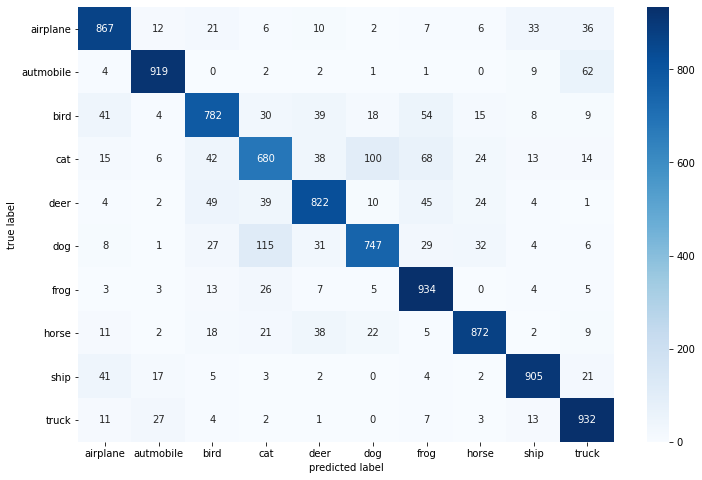

In [42]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

with torch.no_grad():
    cnn.eval()
    y_preds = []
    y_true = []
    # correct = 0
    # total = 0
    for (x_test, y_test) in test_loader:
      out = cnn(x_test.to(device))

      _, preds = torch.max(out.data, 1)
      # total += y_test.shape[0]
      # correct += (preds == y_test.to(device)).sum().item()
      y_preds.append(preds.cpu())
      y_true.append(y_test)

preds = torch.cat(y_preds)
y_true = torch.cat(y_true)

cm = confusion_matrix(y_true, preds)

plt.rcParams['figure.figsize'] = (12, 8)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes.values(), yticklabels=classes.values(), cmap=plt.cm.Blues)
plt.yticks(rotation=0)
plt.xlabel('predicted label')
plt.ylabel('true label')

In [45]:
# correct/total

In [44]:
print(f'accuracy: {accuracy_score(y_true, preds)}')
print(f'f1_micro: {f1_score(y_true, preds, average="micro")}')
print(f'f1_macro: {f1_score(y_true, preds, average="macro")}')

accuracy: 0.846
f1_micro: 0.8459999999999999
f1_macro: 0.8447789396273595


# Check model predictions on random images from internet

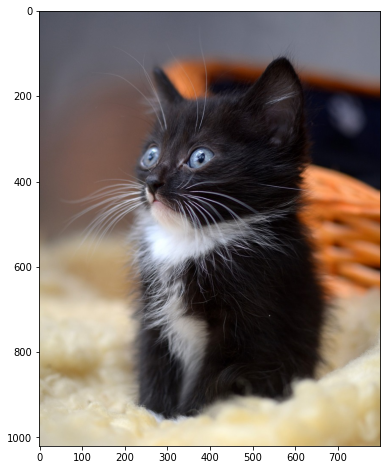

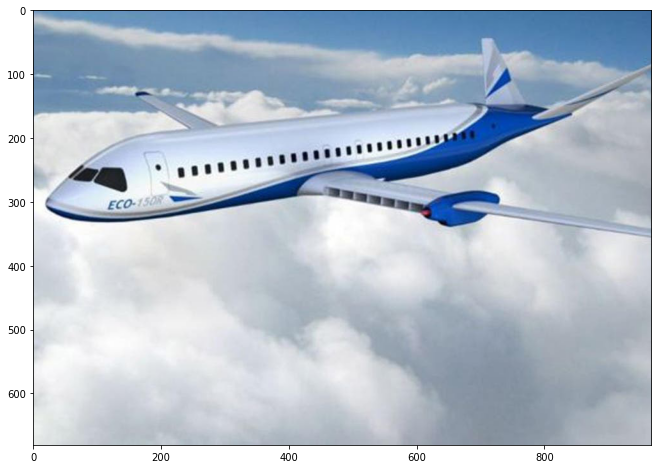

In [165]:
from PIL import Image
import requests
some_cat_img_ulr = 'https://www.rspcasa.org.au/wp-content/uploads/2019/01/Adopt-a-cat-or-kitten-from-RSPCA.jpg'
some_airplane_img_url = 'https://static.independent.co.uk/s3fs-public/thumbnails/image/2017/03/23/17/electricplane.jpg?w968h681'
imgs = []
for url in [some_cat_img_ulr, some_airplane_img_url]:
  res = requests.get(url, stream = True)
  imgs.append(Image.open(res.raw))
  plt.imshow(imgs[-1])
  plt.show()

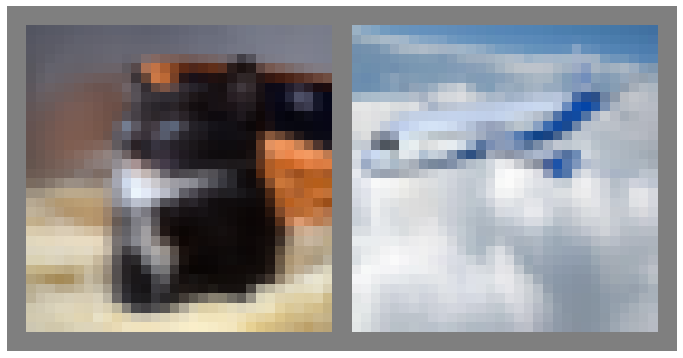

In [166]:
transform = torchvision.transforms.Compose([
                                            torchvision.transforms.Resize((32, 32)), 
                                            torchvision.transforms.ToTensor(), 
                                            torchvision.transforms.Normalize((.5, .5, .5), (.5, .5, .5))
])

imgs = [transform(img) for img in imgs]
img_grid = torchvision.utils.make_grid(imgs)
imshow(img_grid)

                           cat                         airplane


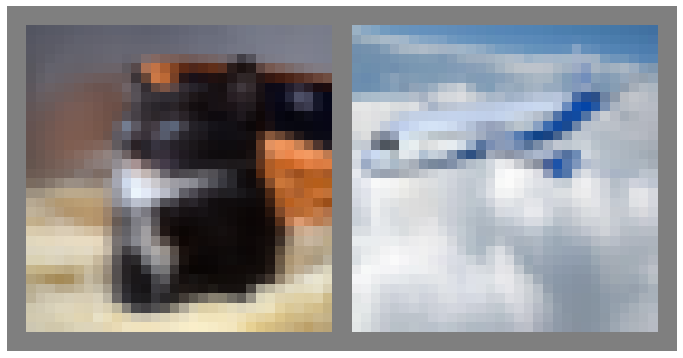

In [216]:
with torch.no_grad():
  cnn.eval()
  out = cnn(torch.stack(imgs).to(device))
  out = F.softmax(out, dim=1)
  preds = torch.argmax(out, dim=1)

print('   '.join('%30s' % classes[pred.item()] for pred in preds))
imshow(img_grid)

# Check how filters in 1st layer look like

(-0.5, 57.5, 29.5, -0.5)

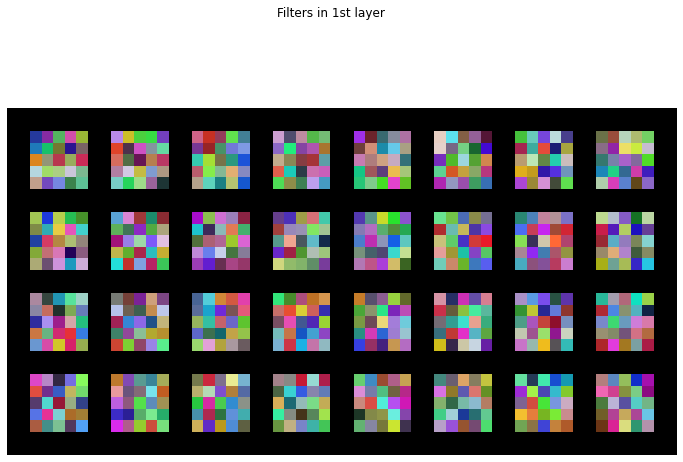

In [38]:
from torchvision.utils import make_grid

kernels = cnn.conv1.weight.detach().cpu().clone()
kernels = kernels - kernels.min()
kernels = kernels / kernels.max()
img = make_grid(kernels)
plt.imshow(img.permute(1, 2, 0))
plt.suptitle('Filters in 1st layer')
plt.axis(False)